In [1]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

/var/folders/b4/spskmk5x6xggprwkxqclxbb40000gn/T/ipykernel_64474/1068979429.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


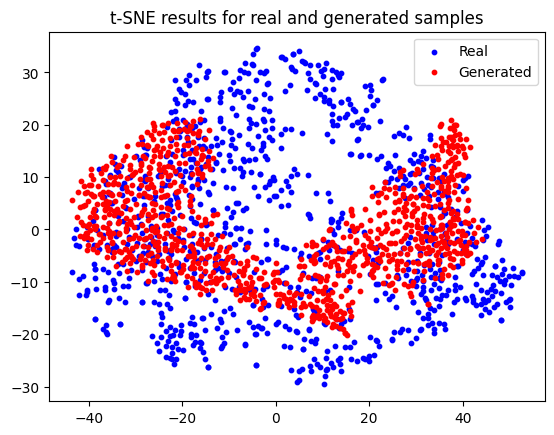

In [2]:
########### ---------------- MODIFY HERE TO MATCH YOUR DATA ---------------- ###########


# import the normalized slices
slices = pd.read_csv('data/slices_normalized.csv', index_col=0)
real_samples = slices.sample(1000)  # Use 10000 random real slices
generated_samples = pd.read_csv('data/generated_samples.csv').values  # Load the generated samples from the CSV file



########### ---------------- t-SNE ---------------- ###########

def time_series_to_2d_points(time_series):
    # Initialize t-SNE
    tsne = TSNE(n_components=2)

    # Fit and transform the data to the first two components
    two_d_points = tsne.fit_transform(time_series)

    return two_d_points

# Convert the samples to 2D points
real_points = time_series_to_2d_points(real_samples)
generated_points = time_series_to_2d_points(generated_samples)

# Plot the t-SNE results
plt.scatter(real_points[:, 0], real_points[:, 1], color='blue', label='Real', s=10)
plt.scatter(generated_points[:, 0], generated_points[:, 1], color='red', label='Generated', s=10)
plt.legend() 
# Add a title
plt.title('t-SNE results for real and generated samples')

plt.show()

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn.model_selection import train_test_split

def train_test_divide(dataX, dataX_hat):
    trainX, testX = train_test_split(dataX, test_size=0.2, random_state=42)
    trainX_hat, testX_hat = train_test_split(dataX_hat, test_size=0.2, random_state=42)
    return trainX, trainX_hat, testX, testX_hat

class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h = torch.relu(self.fc1(x))
        out = self.fc2(h)
        return out, self.sigmoid(out)

def discriminative_score_metrics(dataX, dataX_hat):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Basic Parameters
    No = len(dataX)
    data_dim = len(dataX[0])

    # Network Parameters
    hidden_dim = max(int(data_dim/2),1)
    iterations = 2000
    batch_size = 128

    model = Discriminator(data_dim, hidden_dim).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters())

    # Train / Test Division
    trainX, trainX_hat, testX, testX_hat = train_test_divide(dataX, dataX_hat)

    # Training step
    for itt in range(iterations):
        model.train()
        optimizer.zero_grad()

        # Batch setting
        idx = np.random.permutation(len(trainX))[:batch_size]
        X_mb = torch.stack([trainX[i] for i in idx]).to(device)

        # Batch setting
        idx = np.random.permutation(len(trainX_hat))[:batch_size]
        X_hat_mb = torch.stack([trainX_hat[i] for i in idx]).to(device)

        # Train discriminator
        Y_real, Y_pred_real = model(X_mb)
        Y_fake, Y_pred_fake = model(X_hat_mb)

        D_loss_real = criterion(Y_real, torch.ones_like(Y_real))
        D_loss_fake = criterion(Y_fake, torch.zeros_like(Y_fake))
        D_loss = D_loss_real + D_loss_fake

        D_loss.backward()
        optimizer.step()

    # Final Outputs (on Testing set)
    model.eval()
    with torch.no_grad():
        Y_real, Y_pred_real = model(torch.tensor(testX).to(device))
        Y_fake, Y_pred_fake = model(torch.tensor(testX_hat).to(device))

    Y_pred_final = torch.cat((Y_pred_real, Y_pred_fake), dim=0).cpu().numpy()
    Y_label_final = np.concatenate((np.ones([len(Y_pred_real),]), np.zeros([len(Y_pred_real),])), axis = 0)

    # Accuracy
    Acc = accuracy_score(Y_label_final, Y_pred_final>0.5)

    Disc_Score = np.abs(0.5-Acc)

    return Disc_Score

In [4]:
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

# import the normalized slices
slices = pd.read_csv('data/slices_normalized.csv', index_col=0)
real_samples = slices.sample(1000).values  # Use 1000 random real slices
generated_samples = pd.read_csv('data/generated_samples.csv').values  # Load the generated samples from the CSV file

# Convert real_samples and generated_samples to PyTorch tensors
real_samples = torch.from_numpy(real_samples).float()
generated_samples = torch.from_numpy(generated_samples).float()

scores = []
for i in range(10):

    # Now you can call the function
    disc_score = discriminative_score_metrics(real_samples, generated_samples)
    scores.append(disc_score)

mean = np.mean(scores)
std = np.std(scores)

print('Mean Discriminative Score: %.4f' % mean)
print('Standard Deviation of Discriminative Score: %.4f' % std)

Mean Discriminative Score: 0.4553
Standard Deviation of Discriminative Score: 0.0047


In [5]:
# Assuming real_samples is a numpy array
time_steps = np.arange(1, 101)  # Create a list of integers from 1 to 60

# Create a new array to hold the samples with time steps
real_samples_with_time = np.empty((real_samples.shape[0], real_samples.shape[1], 2))

# Iterate over the rows of real_samples
for i in range(real_samples.shape[0]):
    real_samples_with_time[i] = np.column_stack((real_samples[i, :, np.newaxis], time_steps))

# Create a new array to hold the samples with time steps
generated_samples_with_time = np.empty((generated_samples.shape[0], generated_samples.shape[1], 2))

# Iterate over the rows of generated_samples
for i in range(generated_samples.shape[0]):
    generated_samples_with_time[i] = np.column_stack((generated_samples[i, :, np.newaxis], time_steps))

generated_samples = generated_samples_with_time
real_samples = real_samples_with_time

In [6]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm

class Predictor(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Predictor, self).__init__()
        self.rnn = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return torch.sigmoid(out)

def predictive_score_metrics(dataX, dataX_hat):
    # Basic Parameters
    No = len(dataX)
    data_dim = len(dataX[0][0,:])

    # Network Parameters
    hidden_dim = max(int(data_dim/2),1)
    iterations = 5000 # cahnge this afterwwards
    batch_size = 128

    # Convert data to PyTorch tensors if they are numpy arrays
    if isinstance(dataX, np.ndarray):
        dataX = torch.from_numpy(dataX).float()
    if isinstance(dataX_hat, np.ndarray):
        dataX_hat = torch.from_numpy(dataX_hat).float()

    # Initialize the model, loss function and optimizer
    model = Predictor(data_dim, hidden_dim)
    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters())

    # Train the model on the synthetic data
    for itt in tqdm(range(iterations)):
        idx = torch.randperm(len(dataX_hat))[:batch_size]
        X_mb = dataX_hat[idx, :-1]
        Y_mb = dataX_hat[idx, 1:, -1]
        pred_Y = model(X_mb)
        loss = criterion(pred_Y, Y_mb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluate the model on the original data
    X_mb = dataX[:, :-1]
    Y_mb = dataX[:, -1, -1]
    pred_Y = model(X_mb)

    MAE = mean_absolute_error(Y_mb.detach().numpy(), pred_Y.detach().numpy())
    return MAE    

In [7]:
# now we test the function
predictive_score = predictive_score_metrics(real_samples, generated_samples)

print('Predictive Score: %.4f' % predictive_score)

100%|██████████| 5000/5000 [00:33<00:00, 148.27it/s]

Predictive Score: 99.0066


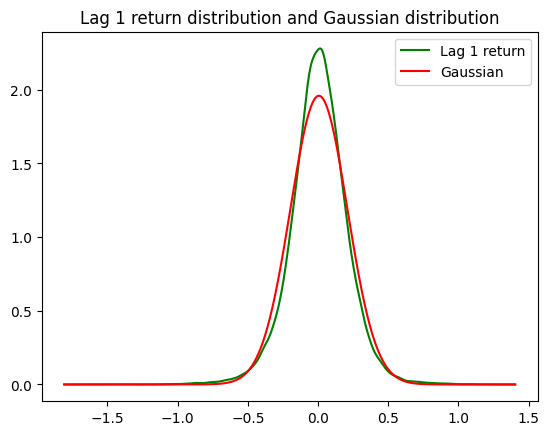

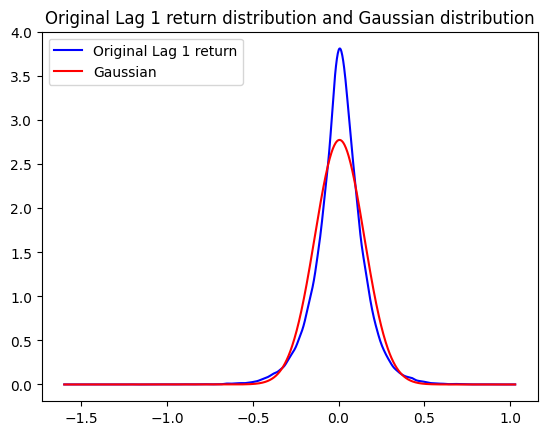

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, gaussian_kde

# Load the generated samples from the CSV file
generated_samples = pd.read_csv('data/generated_samples.csv').values

# Calculate the lag 1 return for each time series
lag_1_returns = [np.diff(time_series) for time_series in generated_samples]

# Flatten the returns to 1D
lag_1_returns = np.concatenate(lag_1_returns)

# Calculate the mean and standard deviation of the returns
mean = np.mean(lag_1_returns)
std = np.std(lag_1_returns)

# Generate a Gaussian distribution with the same mean and standard deviation
gaussian = norm(loc=mean, scale=std)

# Generate values for the x axis
x = np.linspace(min(lag_1_returns), max(lag_1_returns), 1000)

# Estimate the density function of the lag 1 return using KDE
kde = gaussian_kde(lag_1_returns)
lag_1_return_density = kde(x)

# Plot the density function of the lag 1 return
plt.plot(x, lag_1_return_density, color='g', label='Lag 1 return')

# Plot the Gaussian distribution
plt.plot(x, gaussian.pdf(x), 'r', label='Gaussian')

plt.title('Lag 1 return distribution and Gaussian distribution')
plt.legend()
plt.show()

# Load the original data from the CSV file
original_samples = slices.sample(1000).values

# Calculate the lag 1 return for each slicing window
lag_1_returns_original = [np.diff(time_series) for time_series in original_samples]

# Flatten the returns to 1D
lag_1_returns_original = np.concatenate(lag_1_returns_original)

# Calculate the mean and standard deviation of the returns
mean_original = np.mean(lag_1_returns_original)
std_original = np.std(lag_1_returns_original)

# Generate a Gaussian distribution with the same mean and standard deviation
gaussian_original = norm(loc=mean_original, scale=std_original)

# Generate values for the x axis
x_original = np.linspace(min(lag_1_returns_original), max(lag_1_returns_original), 1000)

# Estimate the density function of the lag 1 return using KDE
kde_original = gaussian_kde(lag_1_returns_original)
lag_1_return_density_original = kde_original(x_original)

# Plot the density function of the lag 1 return
plt.plot(x_original, lag_1_return_density_original, color='b', label='Original Lag 1 return')

# Plot the Gaussian distribution
plt.plot(x_original, gaussian_original.pdf(x_original), 'r', label='Gaussian')

plt.title('Original Lag 1 return distribution and Gaussian distribution')
plt.legend()
plt.show()

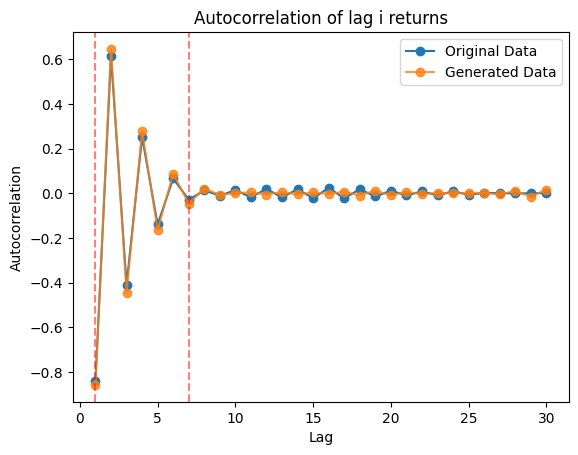

In [9]:
from statsmodels.tsa.stattools import acf


# Calculate the lag i return for each slicing window
lag_returns_original = [np.diff(time_series, n=i) for i in range(1, 31) for time_series in original_samples]

# Exclude short time series
lag_returns_original = [lag_return for lag_return in lag_returns_original if len(lag_return) >= 31]

# Calculate the autocorrelation for each lag
autocorrelations = [acf(lag_return, nlags=30, fft=True) for lag_return in lag_returns_original]

# Calculate the mean autocorrelation for each lag
mean_autocorrelations_original = np.mean(autocorrelations, axis=0)[1:]



# Calculate the lag i return for each generated time series
lag_returns_generated = [np.diff(time_series, n=i) for i in range(1, 31) for time_series in generated_samples]

# Exclude short time series
lag_returns_generated = [lag_return for lag_return in lag_returns_generated if len(lag_return) >= 31]

# Calculate the autocorrelation for each lag
autocorrelations_generated = [acf(lag_return, nlags=30, fft=True) for lag_return in lag_returns_generated]

# Calculate the mean autocorrelation for each lag
mean_autocorrelations_generated = np.mean(autocorrelations_generated, axis=0)[1:]

# Plot the autocorrelation for each lag
plt.plot(range(1, 31), mean_autocorrelations_original, marker='o', label='Original Data')
plt.plot(range(1, 31), mean_autocorrelations_generated, marker='o', label='Generated Data', alpha=0.8)

# Add vertical lines at lag = 1 and lag = 7
plt.axvline(x=1, color='r', linestyle='--', alpha=0.5)
plt.axvline(x=7, color='r', linestyle='--', alpha=0.5)

plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of lag i returns')
plt.legend()
plt.show()

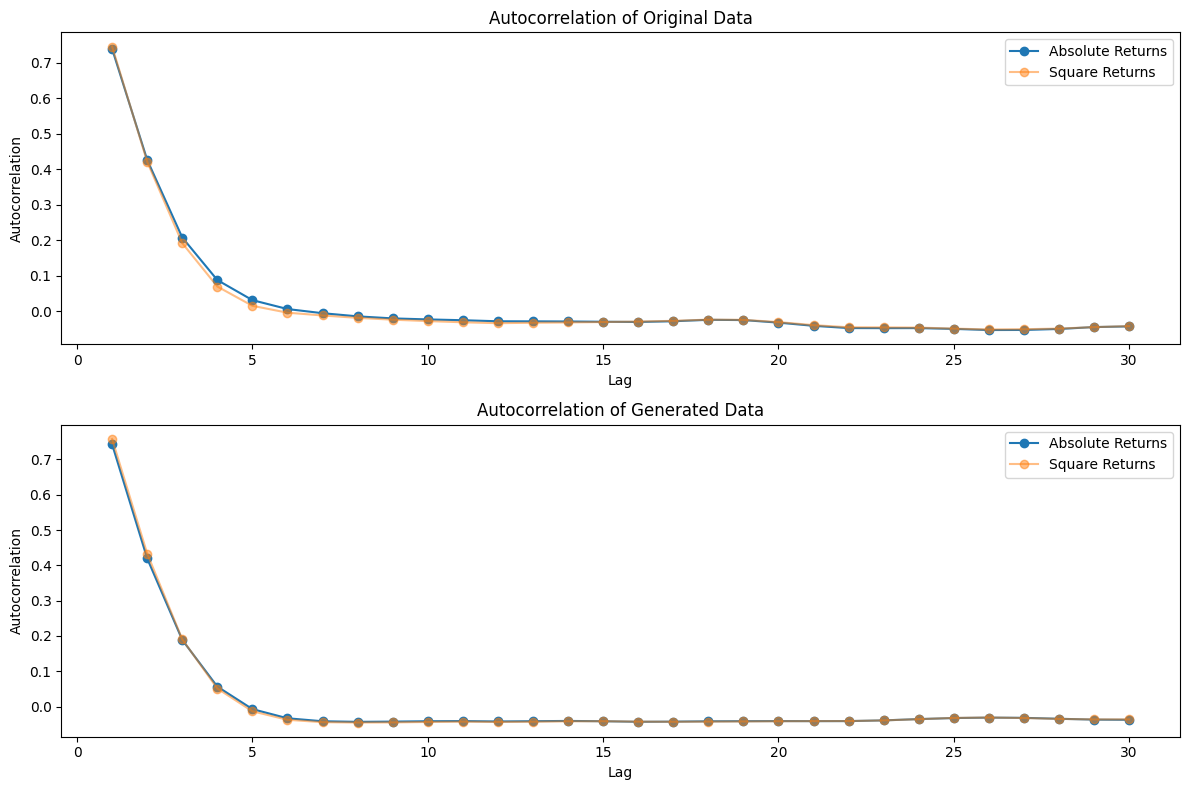

In [10]:
# Calculate the absolute and square returns
abs_returns_original = [np.abs(np.diff(time_series, n=i)) for i in range(1, 31) for time_series in original_samples]
sq_returns_original = [np.diff(time_series, n=i)**2 for i in range(1, 31) for time_series in original_samples]

abs_returns_generated = [np.abs(np.diff(time_series, n=i)) for i in range(1, 31) for time_series in generated_samples]
sq_returns_generated = [np.diff(time_series, n=i)**2 for i in range(1, 31) for time_series in generated_samples]

# Exclude short time series
abs_returns_original = [abs_return for abs_return in abs_returns_original if len(abs_return) >= 31]
sq_returns_original = [sq_return for sq_return in sq_returns_original if len(sq_return) >= 31]

abs_returns_generated = [abs_return for abs_return in abs_returns_generated if len(abs_return) >= 31]
sq_returns_generated = [sq_return for sq_return in sq_returns_generated if len(sq_return) >= 31]


# Calculate the autocorrelation for each lag
autocorrelations_abs_original = [acf(abs_return, nlags=30, fft=True) for abs_return in abs_returns_original]
autocorrelations_sq_original = [acf(sq_return, nlags=30, fft=True) for sq_return in sq_returns_original]

autocorrelations_abs_generated = [acf(abs_return, nlags=30, fft=True) for abs_return in abs_returns_generated]
autocorrelations_sq_generated = [acf(sq_return, nlags=30, fft=True) for sq_return in sq_returns_generated]

# Calculate the mean autocorrelation for each lag
mean_autocorrelations_abs_original = np.mean(autocorrelations_abs_original, axis=0)[1:]
mean_autocorrelations_sq_original = np.mean(autocorrelations_sq_original, axis=0)[1:]

mean_autocorrelations_abs_generated = np.mean(autocorrelations_abs_generated, axis=0)[1:]
mean_autocorrelations_sq_generated = np.mean(autocorrelations_sq_generated, axis=0)[1:]

# Plot the autocorrelation for each lag
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(range(1, 31), mean_autocorrelations_abs_original, marker='o', label='Absolute Returns')
plt.plot(range(1, 31), mean_autocorrelations_sq_original, marker='o', label='Square Returns', alpha=0.5)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of Original Data')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(range(1, 31), mean_autocorrelations_abs_generated, marker='o', label='Absolute Returns')
plt.plot(range(1, 31), mean_autocorrelations_sq_generated, marker='o', label='Square Returns', alpha=0.5)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of Generated Data')
plt.legend()

plt.tight_layout()
plt.show()

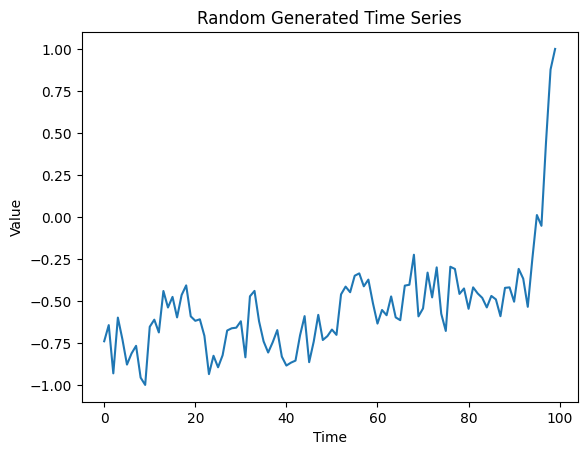

In [27]:
# Select a random time series from the generated data
random_index = np.random.randint(generated_samples.shape[0])
random_series = generated_samples[random_index]

# Plot the time series
plt.plot(random_series)
plt.title('Random Generated Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()